# PowerCo Customer Churn – Modeling & Evaluation Report

**Date:** August 3, 2025  
**Author:** Costas Pinto  
**Status:** Modeling, Evaluation, and Model Export Complete

---

## Step 1: Library Imports and Setup

### Core Libraries:
- `pandas`, `numpy` for data handling  
- `matplotlib`, `seaborn` for visualizations  
- `joblib` for saving models  
- `warnings`, `os` for utility functions  

### ML Libraries:
- `scikit-learn` for Random Forest, data splitting, metrics  
- `lightgbm` for gradient boosting  
- `imblearn` for SMOTE resampling  

### Setup Actions:
- Warnings suppressed for cleaner output  
- Inline plotting enabled  
- Directories prepared:  
  - `datasets/`  
  - `plots/`  
  - `models/`  

---

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# --- Additional Libraries ---
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# --- Setup ---
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
sns.set(style="whitegrid")

class Config:
    """Centralized configuration for the entire pipeline."""
    # Directories
    DATA_DIR = "datasets"
    PLOTS_DIR = "plots"
    MODELS_DIR = "models"
    
    # Filenames
    INPUT_DATA = "data_for_predictions.csv"
    
config = Config()

# Create output directories if they don't exist
os.makedirs(config.PLOTS_DIR, exist_ok=True)
os.makedirs(config.MODELS_DIR, exist_ok=True)

print("Setup Complete.")

Setup Complete.


## Step 2: Data Loading and Preparation

### Actions Taken:
- Loaded dataset: `data_for_predictions.csv`  
- Renamed index column from `"Unnamed: 0"` to `"id"` and set it as the index  
- Split the dataset into:
  - **Features (X)**  
  - **Target (y)** = `'churn'`  

### Train-Test Split:
- Performed stratified 75/25 split to preserve class distribution  
- Ensured reproducibility using `random_state=42`

### SMOTE Resampling:
- Applied **SMOTE** to training data to combat class imbalance  
- Synthetic samples generated only for minority class

---

In [2]:
# Load the dataset
try:
    df = pd.read_csv(os.path.join(config.DATA_DIR, config.INPUT_DATA))
    if "Unnamed: 0" in df.columns:
        df = df.rename(columns={"Unnamed: 0": "id"}).set_index('id')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: '{config.INPUT_DATA}' not found in the '{config.DATA_DIR}' directory.")

# Separate features (X) and target (y)
y = df['churn']
X = df.drop(columns=['churn'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Data preparation and SMOTE resampling complete.")

Dataset loaded successfully.
Data preparation and SMOTE resampling complete.


## Step 3: Model Training

Three models were trained for comparison:

### 1. **Original Random Forest**  
- Trained on imbalanced data  
- Used `class_weight='balanced'` to counter imbalance

### 2. **Random Forest on SMOTE Data**  
- Trained on the balanced dataset created via SMOTE  
- No need for explicit class weighting

### 3. **LightGBM on SMOTE Data**  
- High-performance gradient boosting model  
- Trained on SMOTE-balanced data  
- **Best performing candidate model**

---

In [3]:
# --- 1. Original Random Forest (on original imbalanced data with class_weight) ---
original_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
original_rf.fit(X_train, y_train)

# --- 2. Random Forest on SMOTE Data ---
smote_rf = RandomForestClassifier(random_state=42)
smote_rf.fit(X_train_smote, y_train_smote)

# --- 3. LightGBM on SMOTE Data (The Best Model Candidate) ---
lgbm_model = lgb.LGBMClassifier(objective='binary', random_state=42)
lgbm_model.fit(X_train_smote, y_train_smote)

print("All three models have been trained.")

[LightGBM] [Info] Number of positive: 9890, number of negative: 9890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12045
[LightGBM] [Info] Number of data points in the train set: 19780, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
All three models have been trained.


## Step 4: Model Evaluation & Visualizations

### ROC Curve Comparison:
Plotted ROC curves for all three models to evaluate performance via **AUC (Area Under Curve)**.

- Saved as: `model_comparison_roc.png`
- Key Insight: **SMOTE LightGBM had the highest AUC**, suggesting superior discrimination ability.

### Bar Chart of Classification Metrics:
Compared **Precision, Recall, and F1-Score** for the positive (churned) class.

- Models compared: Original RF, SMOTE RF, SMOTE LightGBM  
- Metrics computed using `classification_report`  
- Visualization saved as: `model_comparison_metrics.png`

---

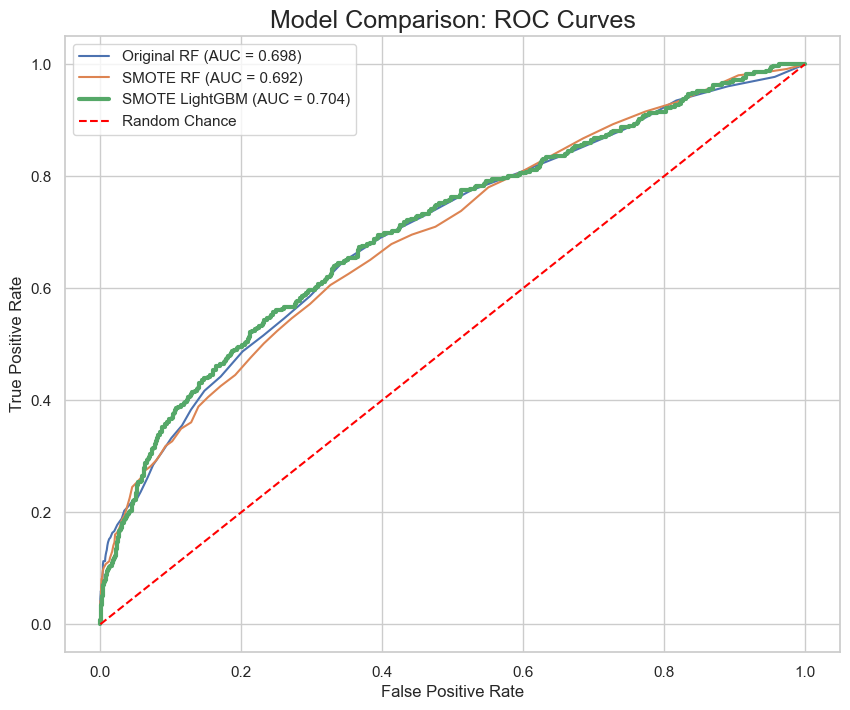

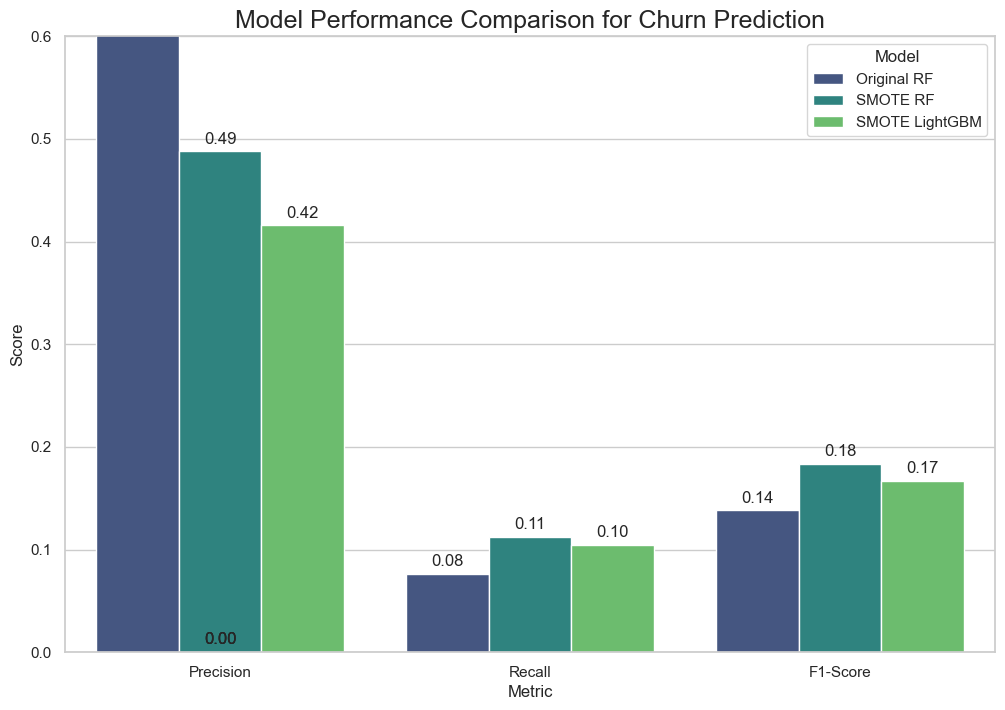

In [4]:
# --- Generate Predictions for All Models ---
y_pred_proba_orig_rf = original_rf.predict_proba(X_test)[:, 1]
y_pred_proba_smote_rf = smote_rf.predict_proba(X_test)[:, 1]
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_orig_rf = original_rf.predict(X_test)
y_pred_smote_rf = smote_rf.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)

# --- Plot 1: ROC Curve Comparison ---
fpr_orig, tpr_orig, _ = metrics.roc_curve(y_test, y_pred_proba_orig_rf)
auc_orig = metrics.roc_auc_score(y_test, y_pred_proba_orig_rf)
fpr_smote_rf, tpr_smote_rf, _ = metrics.roc_curve(y_test, y_pred_proba_smote_rf)
auc_smote_rf = metrics.roc_auc_score(y_test, y_pred_proba_smote_rf)
fpr_lgbm, tpr_lgbm, _ = metrics.roc_curve(y_test, y_pred_proba_lgbm)
auc_lgbm = metrics.roc_auc_score(y_test, y_pred_proba_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_orig, tpr_orig, label=f'Original RF (AUC = {auc_orig:.3f})')
plt.plot(fpr_smote_rf, tpr_smote_rf, label=f'SMOTE RF (AUC = {auc_smote_rf:.3f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'SMOTE LightGBM (AUC = {auc_lgbm:.3f})', linewidth=3)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.title('Model Comparison: ROC Curves', fontsize=18)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(os.path.join(config.PLOTS_DIR, 'model_comparison_roc.png'), bbox_inches='tight')
plt.show()

# --- Plot 2: Performance Metrics Bar Chart ---
metrics_data = []
models = ['Original RF', 'SMOTE RF', 'SMOTE LightGBM']
predictions = [y_pred_orig_rf, y_pred_smote_rf, y_pred_lgbm]
for model_name, y_pred in zip(models, predictions):
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    metrics_data.append({
        'Model': model_name,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })
metrics_df = pd.DataFrame(metrics_data)
melted_df = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Metric", y="Score", hue="Model", data=melted_df, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Model Performance Comparison for Churn Prediction', fontsize=18)
plt.ylabel('Score')
plt.ylim(0, 0.6)
plt.savefig(os.path.join(config.PLOTS_DIR, 'model_comparison_metrics.png'), bbox_inches='tight')
plt.show()

## Step 5: Model Export

### Actions:
- Saved **LightGBM model** to disk as `churn_lgbm_model.joblib` in the `models/` directory using `joblib.dump`

### Verification:
- Re-loaded the model from disk using `joblib.load`
- Performed prediction on sample test rows to confirm integrity

In [5]:
# Define the file path for the saved model
model_path = os.path.join(config.MODELS_DIR, 'churn_lgbm_model.joblib')

# Save the model
joblib.dump(lgbm_model, model_path)

print(f"Best performing model (LightGBM) saved successfully to: {model_path}")

# --- Verification Step ---
loaded_model = joblib.load(model_path)
print("\nVerification: Model loaded successfully.")
sample_predictions = loaded_model.predict(X_test.head())
print("Sample prediction on test data using loaded model:", sample_predictions)

Best performing model (LightGBM) saved successfully to: models\churn_lgbm_model.joblib

Verification: Model loaded successfully.
Sample prediction on test data using loaded model: [0 0 0 0 0]
